# **PROJECT: STOCK PREDICTION WITH LSTM**

An LSTM Network is capable of “remembering” relevant data in the sequence and preserving it for several moments of time. Therefore, it can have both a short-term memory (like basic Recurrent Networks) and also a long-term memory. These are some of its capabilities:

1. Handling temporal data sequences: LSTM networks are particularly effective for modeling and predicting sequential data, such as time series. This is due to its inherent ability to remember relevant information from past events as it progresses through the sequence.

2. Handling long-term dependencies: LSTMs are designed to handle long-term dependencies in data, making them suitable for capturing complex patterns and temporal relationships in time series that can span long periods of time.

3. Long-term memory capacity: Unlike traditional recurrent neural networks (RNNs), LSTMs are equipped with gate mechanisms (such as input, forget, and output gates) that allow them to maintain and update information over time , making them more effective at remembering and using important information from past events.

4. Preventing gradient fading problems: LSTMs are designed to mitigate gradient fading problems that can arise in simpler recurrent neural networks, allowing them to learn long-term dependencies more effectively.

5. Adaptability to different time scales: LSTM networks can adapt to different time scales in the data, making them useful for predicting short-, medium- and long-term time series.

**In summary, LSTM networks are a common choice for time series prediction projects due to their ability to model complex temporal relationships, remember long-term information, and mitigate problems associated with time dependence and gradient vanishing.**

**Despite these limitations, LSTMs remain a powerful and widely used tool in the field of deep learning for a variety of sequence modeling applications. The choice to use an LSTM will depend on the nature of the problem and the resources available.**

 ## **IMPORTING THE  NECESSARY LIBRARIES**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [2]:
# Allows us to connect to our google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **LOAD DATA**

**This data set contains the historical record of the behavior of Apple's stock between January 2006 and December 2017.**



In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/apple_stocks.csv', index_col='Date', parse_dates=['Date'])

In [5]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 3019 rows and 6 columns


When viewing the content of this dataset we can see that each record contains the information of the highest and lowest values ​​reached by the action, as well as the opening and closing values ​​and the volume of the transactions:

In [6]:
df.sample(10)

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2009-04-20,17.39,17.57,17.02,17.21,116663519,AAPL
2012-03-27,86.60,88.04,86.58,87.78,151782141,AAPL
2013-02-25,64.84,65.02,63.22,63.26,93144464,AAPL
2010-02-10,27.98,28.09,27.75,27.87,92590218,AAPL
2006-12-27,11.16,11.71,10.97,11.65,485160788,AAPL
2011-06-02,49.50,49.71,49.19,49.44,84721112,AAPL
2016-05-16,92.39,94.39,91.65,93.88,61140610,AAPL
2007-06-01,17.30,17.31,16.90,16.91,221443390,AAPL
2012-09-10,97.21,97.61,94.59,94.68,121998898,AAPL


We will train the LSTM Network using only the highest value of the action (High column in the data set).

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3019 non-null   float64
 1   High    3019 non-null   float64
 2   Low     3019 non-null   float64
 3   Close   3019 non-null   float64
 4   Volume  3019 non-null   int64  
 5   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 165.1+ KB


**No missing Values, No need to encode the data.**

### **DATA PRE-PROCESSING**

**Training and validation sets.**

The LSTM will be trained with data prior to 2016. Validation will be done with data after 2017.
In both cases, only the highest value of the action for each day will be used. The idea is that the LSTM Network learns to predict the maximum values ​​of the stock for the year 2017, using the behavior in previous years:

In [3]:
np.random.seed(4)

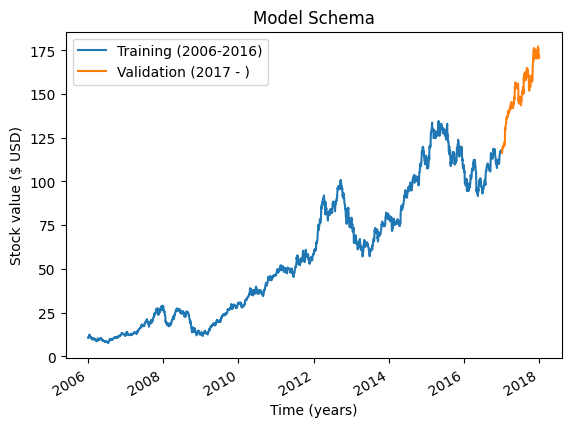

In [8]:
training_set = df[:'2016'].iloc[:,1:2]
validation_set = df['2017':].iloc[:,1:2]

training_set['High'].plot(legend=True)
validation_set['High'].plot(legend=True)
plt.ylabel('Stock value ($ USD)')
plt.xlabel('Time (years)')
plt.title('Model Schema')
plt.legend(['Training (2006-2016)', 'Validation (2017 - )'])
plt.show()

### **DATA NORMALISATION** 
For the LSTM Network to be trained, the stock values ​​must be in a defined range. So let's use the Scikit-learn library to normalize these values ​​in the range 0 to 1, using the MinMaxScaler function:

In [9]:
scaled = MinMaxScaler(feature_range=(0,1))
scaled_training_set = scaled.fit_transform(training_set)

And once the training is done, at the time of prediction, we will perform the inverse transformation to obtain the values ​​on the real scale.

###**Adjusting training and validation sets.**
The LSTM network will have consecutive data as input "time_step", and 1 data as output (the prediction from that "time_step" data).

To train the LSTM Network we will take blocks of 7 consecutive data, and the idea is that each of these allows us to predict the next value.

The blocks of 7 data will be stored in the variable "X", while the data that must be predicted (data 8 within each sequence) will be stored in the variable "Y" and will be used as the output of the LSTM Network:

In [11]:
time_step = 7
X_train = []
Y_train = []
m = len(scaled_training_set)

for i in range(time_step,m):
    # X: "time_step" blocks: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(scaled_training_set[i-time_step:i,0])

    # Y: Next data
    Y_train.append(scaled_training_set[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

In the previous code we use the for loop to iteratively divide the training set into blocks of 7 data and store the corresponding blocks in different positions of the variables X_train and Y_train.

Before creating the LSTM Network we must readjust the sets that we have just obtained, to indicate that each training example at the input of the model will be a 7x1 vector. For this we use Numpy's reshape function:

In [12]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In the case of each of the outputs (stored in Y_train) we must simply specify that its size will be equal to 1, which corresponds to the only value predicted by the network.

### **CREATION AND TRAINING OF THE LSTM NETWORK**
To create the network we must first define the size of the input data and the output data, as well as the total number of neurons (100):

In [13]:
input_data_size = (X_train.shape[1],1)
output_data_size = 1
neurons = 100

We will use the Sequential module to create the container, to which we will add the LSTM Network (using the LSTM module) and the output layer (using the Dense module):

In [14]:
model = Sequential()
model.add(LSTM(units=neurons, input_shape=input_data_size))
model.add(Dropout(0.2))  # Regularization with a 20% Dropout ratio to avoid overfitting
model.add(Dense(units=output_data_size))
model.compile(optimizer='rmsprop', loss='mse')
model.fit(X_train, Y_train, epochs=20, batch_size=32)

Epoch 1/20
87/87 [==============================] - 3s 7ms/step - loss: 0.0093
Epoch 2/20
87/87 [==============================] - 1s 7ms/step - loss: 0.0019
Epoch 3/20
87/87 [==============================] - 1s 7ms/step - loss: 0.0015
Epoch 4/20
87/87 [==============================] - 1s 7ms/step - loss: 0.0015
Epoch 5/20
87/87 [==============================] - 1s 7ms/step - loss: 0.0013
Epoch 6/20
87/87 [==============================] - 1s 8ms/step - loss: 0.0013
Epoch 7/20
87/87 [==============================] - 1s 10ms/step - loss: 0.0013
Epoch 8/20
87/87 [==============================] - 1s 11ms/step - loss: 0.0011
Epoch 9/20
87/87 [==============================] - 1s 10ms/step - loss: 0.0011
Epoch 10/20
87/87 [==============================] - 1s 11ms/step - loss: 0.0010
Epoch 11/20
87/87 [==============================] - 1s 11ms/step - loss: 8.8071e-04
Epoch 12/20
87/87 [==============================] - 1s 11ms/step - loss: 0.0010
Epoch 13/20
87/87 [====================

The LSTM Network is added using the add function, specifying the number of neurons to use (**units** parameter) and the size of each input data (**input_shape** parameter).

We use the **Dropout** regularization technique with a ratio of 20% to avoid overfitting, randomly disabling a fraction of the units during training.

For the output layer we use the **Dense** function and specify that the output data will have a size equal to 1 (units parameter).

The model is then compiled, thus defining the error function (**loss** parameter) as well as the method that will be used to minimize it (**optimize** parameter).

The selected optimizer (**rmsprop**) works similarly to the Gradient Descent algorithm, while the error function is the root mean square error.

Training is easily implemented using the fit function. In this case we will use a total of 20 iterations (**epochs** parameter) and we will present batches of 32 data to the LSTM Network (**batch_size** parameter).

### **STOCK VALUE PREDICTION**
With the model trained, let's see how well this LSTM Network predicts the stock values.

Initially we must prepare the validation set, initially normalizing the data, in the range from 0 to 1, for which we use the transformation implemented previously on the training set:

In [15]:
x_test = validation_set.values
x_test = scaled.transform(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Let's remember that the model was trained to take 7 data and generate a data as a prediction. So we need to reorganize the validation set (x_test) so that it has blocks of 7 data:

In [16]:
X_test = []
validation_dates = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
    validation_dates.append(validation_set.index[i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

And finally we make the prediction using the predict function and we apply the inverse normalization of said prediction so that it is on the real scale of the stocks:

8/8 [==============================] - 0s 4ms/step


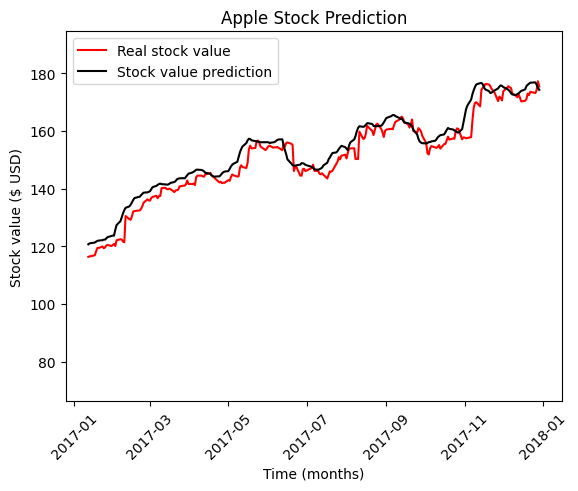

In [17]:
prediction = model.predict(X_test)
prediction = scaled.inverse_transform(prediction)

def prediction_graph(real, prediction, validation_dates):
    plt.plot(validation_dates[0:len(prediction)], real[0:len(prediction)], color='red', label='Real stock value')
    plt.plot(validation_dates[0:len(prediction)], prediction, color='black', label='Stock value prediction')
    plt.ylim(1.1 * np.min(prediction) / 2, 1.1 * np.max(prediction))
    plt.xlabel('Time (months)')
    plt.ylabel('Stock value ($ USD)')
    plt.title('Apple Stock Prediction')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

prediction_graph(validation_set.values, prediction, validation_dates)

### **CONCLUSION**

It is really a preliminary model that can be improved, for example:

1. by tuning the hyperparameters (number of neurons, LSTM layers, learning rate)
2. Adding cross validation
3. Increasing the data set

However, this model simply illustrates how to implement an LSTM Network capable of fairly approximately predicting the behavior of a stock on the stock market.